In [1]:
import os 
cwd = os.getcwd()
import sys
sys.path.append("C:/Users/gomel/Documents/global_python_codes/Metrics_thresholds_boots") # go to parent dir

sys.path.append("C:/Users/gomel/Documents/Programing Proyects/EE indicators/Simulations with pdfs to test/Stochastic equations/SDE tests jupyter") # go to parent dir
import sde_analysis as sa

import sympy as sp
import ewstools as ews
import numpy as np
import sdeint
import metrics
import boots as bts
import scipy.stats as st
import astropy.stats as astrost
import scipy.signal as sg
from scipy import special

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif"    
})
import matplotlib.lines as lines
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

from sympy import lambdify

c1=(221/256,170/256,51/256)
c2=(187/256,85/256,102/256)
c3=(0,68/256,136/256)
cols=(c1,c2,c3)

This is a simulation of a subcritical hopf equation with aditive noise using a Heun method where the noise only applies on the variable and not the parameter. 


\begin{equation}
\begin{aligned}
\dot{r}&=\mu r + r^3 -r^5\\
\dot{\theta}&=\omega + br^2
\end{aligned} 
\end{equation}
where $x$ is a random variable and $\mu$ is a swiped parameter determined by $\dot{\mu}=\mu_v$. Here $\mu_v$ should be small enough for the parameter to be moving 'adiabatically' with respect to the dynamics of the system. 


This system has three fixed points, $r={0,\pm \sqrt{1/2}\sqrt{1\pm\sqrt{1+4\mu}}}$ that switch stability depending on the sign of $\mu$.
By starting with an initial condition $r=1.5,\mu_0=5$ we stay on the stable manifold after crossing the threshold $\mu=0$ and the system goes through a tipping point to another stable solution.


..
The stochastic equation is 


\begin{equation}
\begin{aligned}
\dot{r}&=\mu r + r^3 -r^5+\sigma dW\\
\dot{\theta}&=\omega + br^2
\end{aligned} 
\end{equation}
where W is a (0,1) white noise process and $\sigma$ the intensity of the noise.



In [2]:
def stiched_colormap(cmap1,cmap2,stich_point):
    from matplotlib.colors import ListedColormap, LinearSegmentedColormap
    import matplotlib.cm as cm
    #stich_point=70
    c1=cm.get_cmap(cmap1,stich_point)
    cdis=c1(range(0,100))
    c2=cm.get_cmap(cmap2, 100-stich_point)
    cdis2=c2(range(0,100-stich_point))
    cdis[stich_point:100]=cdis2[::-1]
    cdis = ListedColormap(cdis)
    return cdis

cdis=stiched_colormap('cividis','BuPu',50)

def m_sol1(mvar):
    mv=mvar[mvar>-0.25]
    return 1/np.sqrt(2)*np.sqrt(1+np.sqrt(1+4*mv))


In [3]:
l0=1
lf=3

s=0.01

K=5.2
r=1
b=1

In [4]:
ns, ps, ls = sp.symbols('N P lambda')

eq1=(r*ns*(1-ns/K)-ls*ns**2/(b**2+ns**2))

sp.solve(eq1,ns)


[0.0,
 -0.0582482260286442*(24.04 - 15.6*lambda)/(0.649278579356271*lambda + (-0.395573452799655*(1 - 0.64891846921797*lambda)**3 + (0.649278579356271*lambda - 1)**2)**0.5 - 1)**(1/3) - 1.90754497924917*(0.649278579356271*lambda + (-0.395573452799655*(1 - 0.64891846921797*lambda)**3 + (0.649278579356271*lambda - 1)**2)**0.5 - 1)**(1/3) + 1.73333333333333,
 -0.0582482260286442*(-0.5 - 0.866025403784439*I)*(24.04 - 15.6*lambda)/(0.649278579356271*lambda + (-0.395573452799655*(1 - 0.64891846921797*lambda)**3 + (0.649278579356271*lambda - 1)**2)**0.5 - 1)**(1/3) - 1.90754497924917*(-0.5 + 0.866025403784439*I)*(0.649278579356271*lambda + (-0.395573452799655*(1 - 0.64891846921797*lambda)**3 + (0.649278579356271*lambda - 1)**2)**0.5 - 1)**(1/3) + 1.73333333333333,
 -0.0582482260286442*(-0.5 + 0.866025403784439*I)*(24.04 - 15.6*lambda)/(0.649278579356271*lambda + (-0.395573452799655*(1 - 0.64891846921797*lambda)**3 + (0.649278579356271*lambda - 1)**2)**0.5 - 1)**(1/3) - 1.90754497924917*(-0.5 

### Characteristic time-scale exploration

First we do a deterministic integration to estimate the time-scale of the transition.

$\Delta t= $ 0.001 t_final: 1000
data length:  1000000


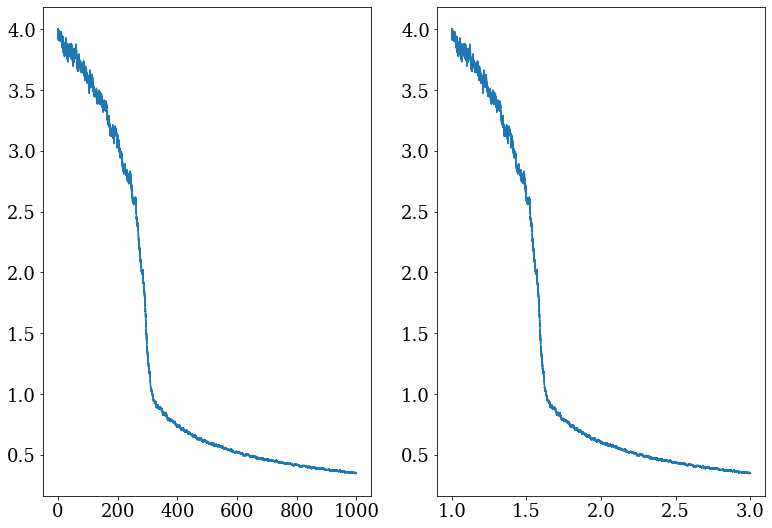

In [5]:
datalen=0.001
t_final=1000

s=0.01


tspan=np.arange(0,t_final,datalen)

cl=(lf-l0)/t_final
print(r'$\Delta t= $', tspan[1]-tspan[0], 't_final:', t_final)
print('data length: ', len(tspan))

x0 = np.array([4])


def f(x, t):

    l=l0+cl*t
    A=np.array([r*x[0]*(1-x[0]/K)-l*x[0]**2/(b**2+x[0]**2)])
    return A

def G(x, t):
    #B=[ 'noise in x'         0    ]
    #  [      0        'noise in r']
    B = np.diag([s*x[0]]) # diagonal, so independent driving Wiener processes
    #the only parameter with relevant aditive noise is X(t) in this case. 
    return B


result = sdeint.stratHeun(f, G, x0, tspan)

l=l0+cl*tspan


N=result[:,0]

plt.figure(figsize=(20,9))
plt.subplot(131)
plt.plot(tspan,N)
plt.subplot(132)
plt.plot(l,N)

In [6]:
res=N[::1000]


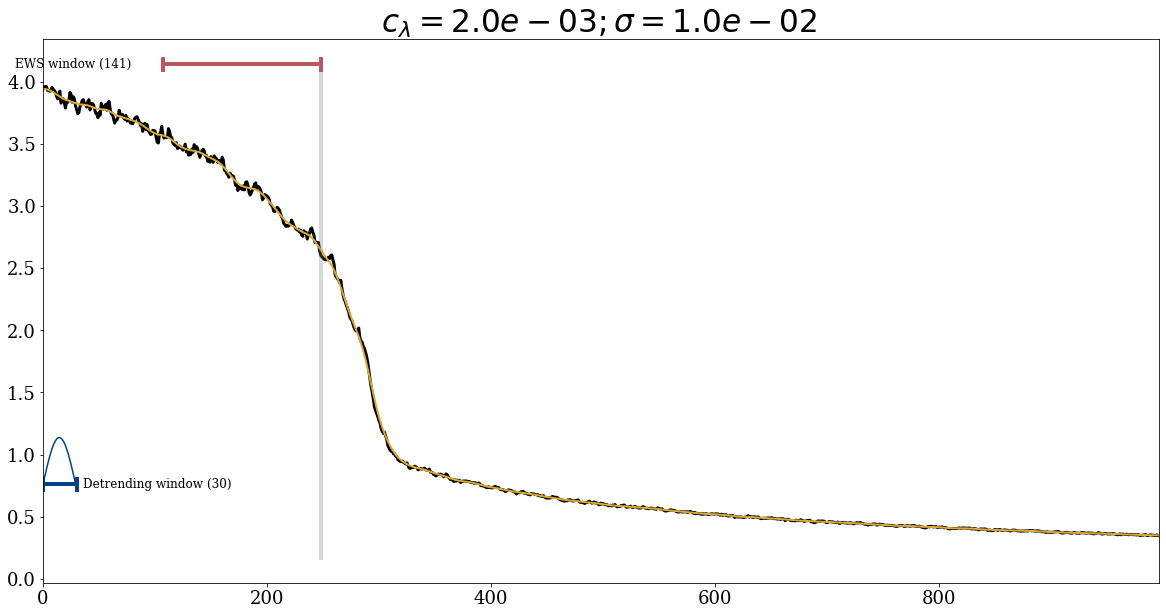

In [7]:
from scipy import signal
res=res[2:]
lskimmed=l[::1000]
lskimmed=lskimmed[2:]

bootstrapping=False
smoothing=True

bif_idx=np.abs(1.5-lskimmed).argmin()

trans=bif_idx
dlen=len(res)
t=np.arange(0,len(res),1)
ind_f=t

varwin=np.int64(30)
ewswin=np.int64(141)
ts = ews.TimeSeries(data=res)  ### ews stats ### 

bw=varwin/2
if smoothing==True:
    ts.detrend(method='Gaussian',bandwidth=bw, span=varwin)
    smooth=ts.state['smoothing'].values
    residuals=ts.state['residuals'].values
    data=residuals

    fig=plt.figure(figsize=(20,10))
    ax=fig.add_subplot(111)
    plt.plot(t,res,'-',color='black',lw=3)
    plt.plot(t,smooth,color=c1,lw=2)
    plt.xlim(t[0],t[-1])

    sa.plot_detrend_data(fig, ewswin,varwin,bw,trans)
ax.set_title(r'$c_\lambda=%.1e ; \sigma=%.1e $ '%(cl,s))

ylim=ax.get_ylim()
plt.rc('font',size=26)


#adiab_idx=np.abs(-adiab-l).argmin()
#adiab2_idx=np.abs(-adiab2-l).argmin()
#adiab3_idx=np.abs(-adiab3-l).argmin()

fig.savefig('./detrend_multiplicative.png'  , dpi = 130, bbox_inches='tight')# when saving, specify the DPI

In [8]:
tidx,ac_labels,ac1,ac2,var_ews,sk_ews,ku_ews,rtw,hogg2,moors,RTWc= sa.make_stats(tspan,t,ts,varwin,ewswin,sm=smoothing)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


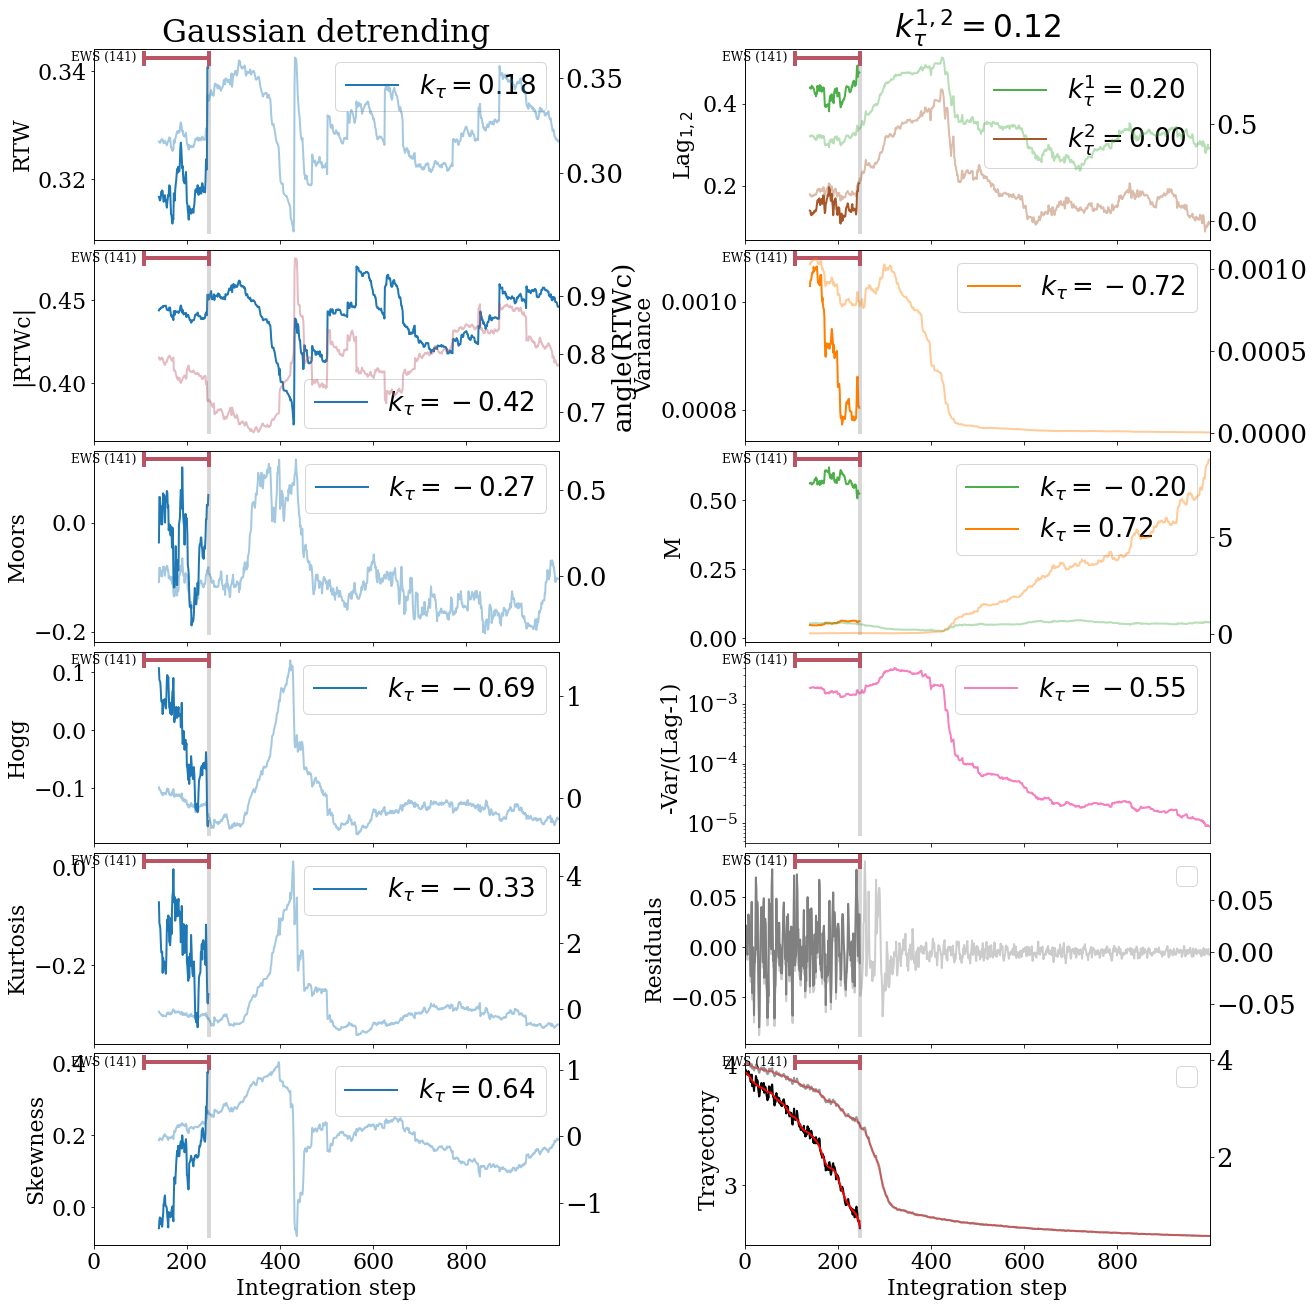

In [9]:
fig=sa.stats_plot(bif_idx,tidx,ind_f,s,rtw,RTWc,moors,hogg2,ac1,ku_ews,sk_ews,ac2,var_ews,residuals,res,smooth,smoothing,ewswin,datalen*1000)
fig.savefig('./Gdet_multiplicative.png'  , dpi = 130, bbox_inches='tight')# when saving, specify the DPI

In [10]:

bootstrapping=False
smoothing=False

ts = ews.TimeSeries(data=res)  ### ews stats ### 
tidx,ac_labels,ac1,ac2,var_ews,sk_ews,ku_ews,rtw,hogg2,moors,RTWc= sa.make_stats(tspan,t,ts,varwin,ewswin)

if bootstrapping==True:
    dlen=len(ac1)
    mean_b=np.zeros([dlen,2])
    var_b=np.zeros([dlen,2])
    skew_b=np.zeros([dlen,2])
    kur_b=np.zeros([dlen,2])
    kr2_b=np.zeros([dlen,2])
    kr3_b=np.zeros([dlen,2])
    RTW_b=np.zeros([dlen,2])
    ac1_std=np.zeros([dlen,2])

fig=sa.stats_plot(bif_idx,tidx,ind_f,s,rtw,RTWc,moors,hogg2,ac1,ku_ews,sk_ews,ac2,var_ews,residuals,res,smooth,smoothing,ewswin,datalen*1000)
fig.savefig('./No_det_multiplivative.png'  , dpi = 130, bbox_inches='tight')# when saving, specify the DPI

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [11]:
#test here change the bootstrapping of the high order stats

In [12]:
datalen=0.001
t_final=1000

s=0.01


tspan=np.arange(0,t_final,datalen)

cl=(lf-l0)/t_final
print(r'$\Delta t= $', tspan[1]-tspan[0], 't_final:', t_final)
print('data length: ', len(tspan))


def f(x, t):

    l=l0+cl*t
    A=np.array([r*x[0]*(1-x[0]/K)-l*x[0]**2/(b**2+x[0]**2)])
    return A

def G(x, t):
    #B=[ 'noise in x'         0    ]
    #  [      0        'noise in r']
    B = np.diag([0.01]) # diagonal, so independent driving Wiener processes
    #the only parameter with relevant aditive noise is X(t) in this case. 
    return B


result = sdeint.stratHeun(f, G, x0, tspan)

l=l0+cl*tspan


N=result[:,0]

plt.figure(figsize=(20,9))
plt.subplot(131)
plt.plot(tspan,N)
plt.subplot(132)
plt.plot(l,N)

res=N[::1000]


$\Delta t= $ 0.001 t_final: 1000
data length:  1000000


In [13]:
from scipy import signal
res=res[2:]
lskimmed=l[::1000]
lskimmed=lskimmed[2:]

bootstrapping=False
smoothing=True

bif_idx=np.abs(1.5-lskimmed).argmin()

trans=bif_idx
dlen=len(res)
t=np.arange(0,len(res),1)
ind_f=t

ts = ews.TimeSeries(data=res)  ### ews stats ### 

if smoothing==True:
    ts.detrend(method='Gaussian',bandwidth=bw, span=varwin)
    smooth=ts.state['smoothing'].values
    residuals=ts.state['residuals'].values
    data=residuals

    fig=plt.figure(figsize=(20,10))
    ax=fig.add_subplot(111)
    plt.plot(t,res,'-',color='black',lw=3)
    plt.plot(t,smooth,color=c1,lw=2)
    plt.xlim(t[0],t[-1])

    sa.plot_detrend_data(fig, ewswin,varwin,bw,trans)
ax.set_title(r'$c_\lambda=%.1e ; \sigma=%.1e $ '%(cl,s))

ylim=ax.get_ylim()
plt.rc('font',size=26)

#adiab_idx=np.abs(-adiab-l).argmin()
#adiab2_idx=np.abs(-adiab2-l).argmin()
#adiab3_idx=np.abs(-adiab3-l).argmin()

fig.savefig('./detrend_additive.png'  , dpi = 130, bbox_inches='tight')# when saving, specify the DPI


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


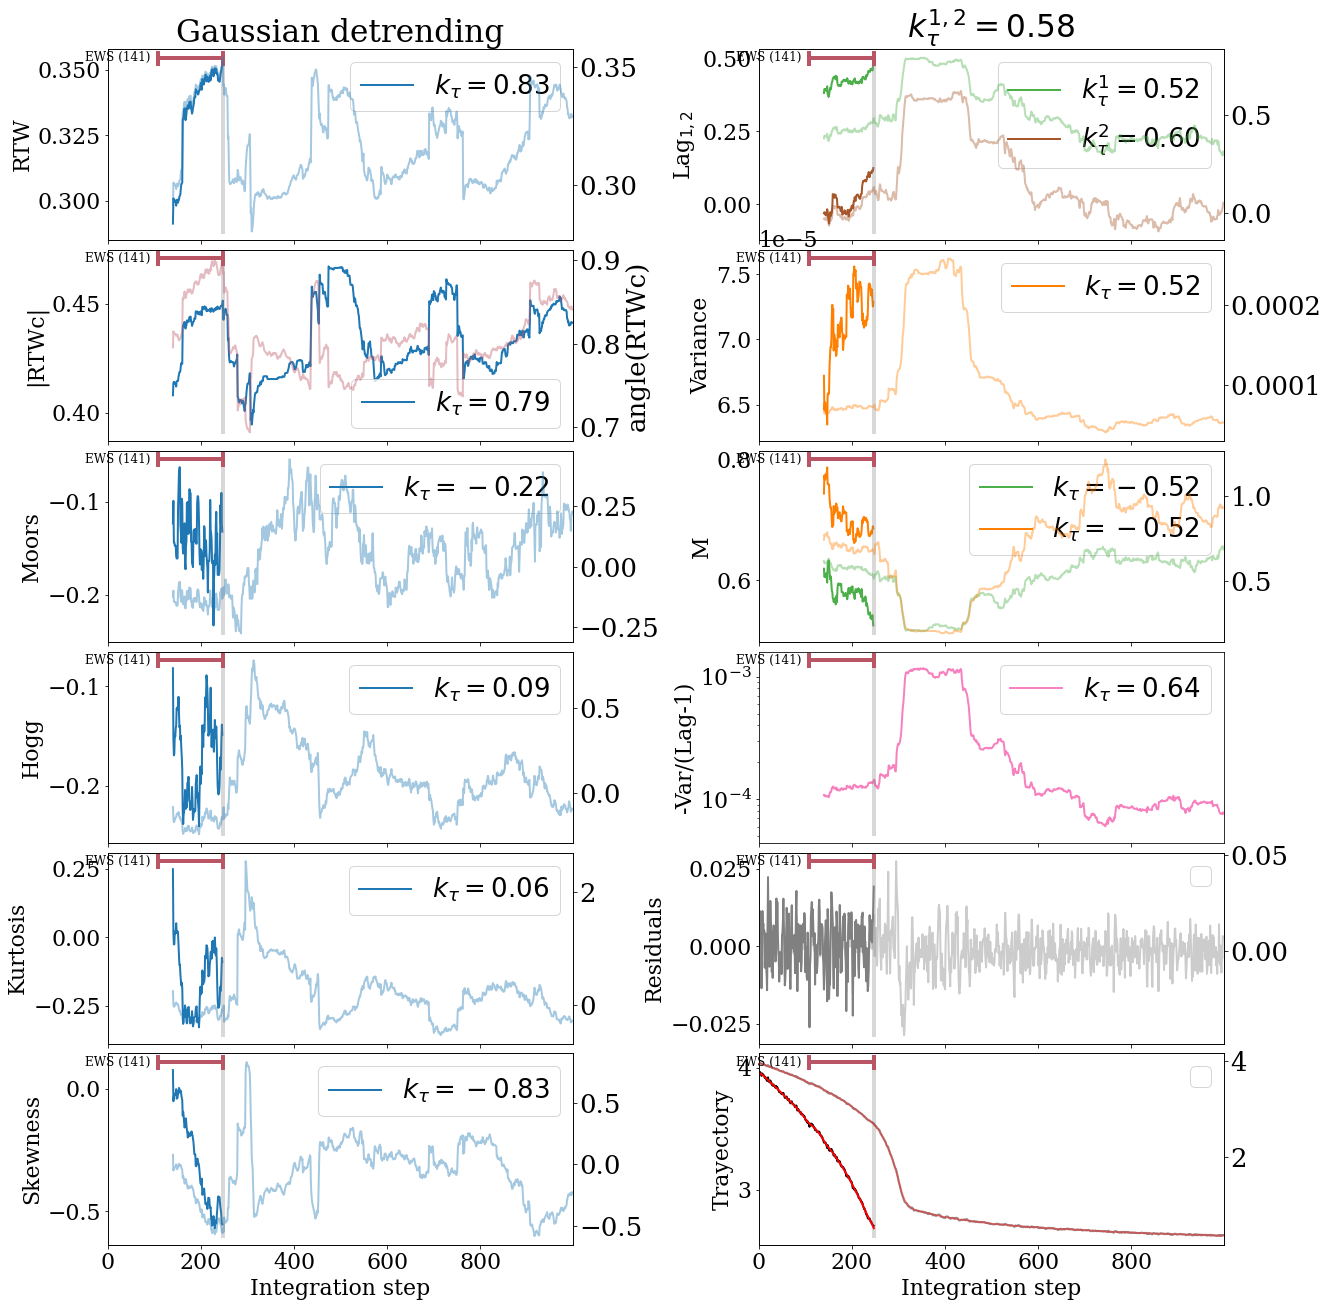

In [14]:
tidx,ac_labels,ac1,ac2,var_ews,sk_ews,ku_ews,rtw,hogg2,moors,RTWc= sa.make_stats(tspan,t,ts,varwin,ewswin,sm=smoothing)
fig=sa.stats_plot(bif_idx,tidx,ind_f,s,rtw,RTWc,moors,hogg2,ac1,ku_ews,sk_ews,ac2,var_ews,residuals,res,smooth,smoothing,ewswin,datalen*1000)
fig.savefig('./Gdet_additive.png'  , dpi = 130, bbox_inches='tight')# when saving, specify the DPI

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


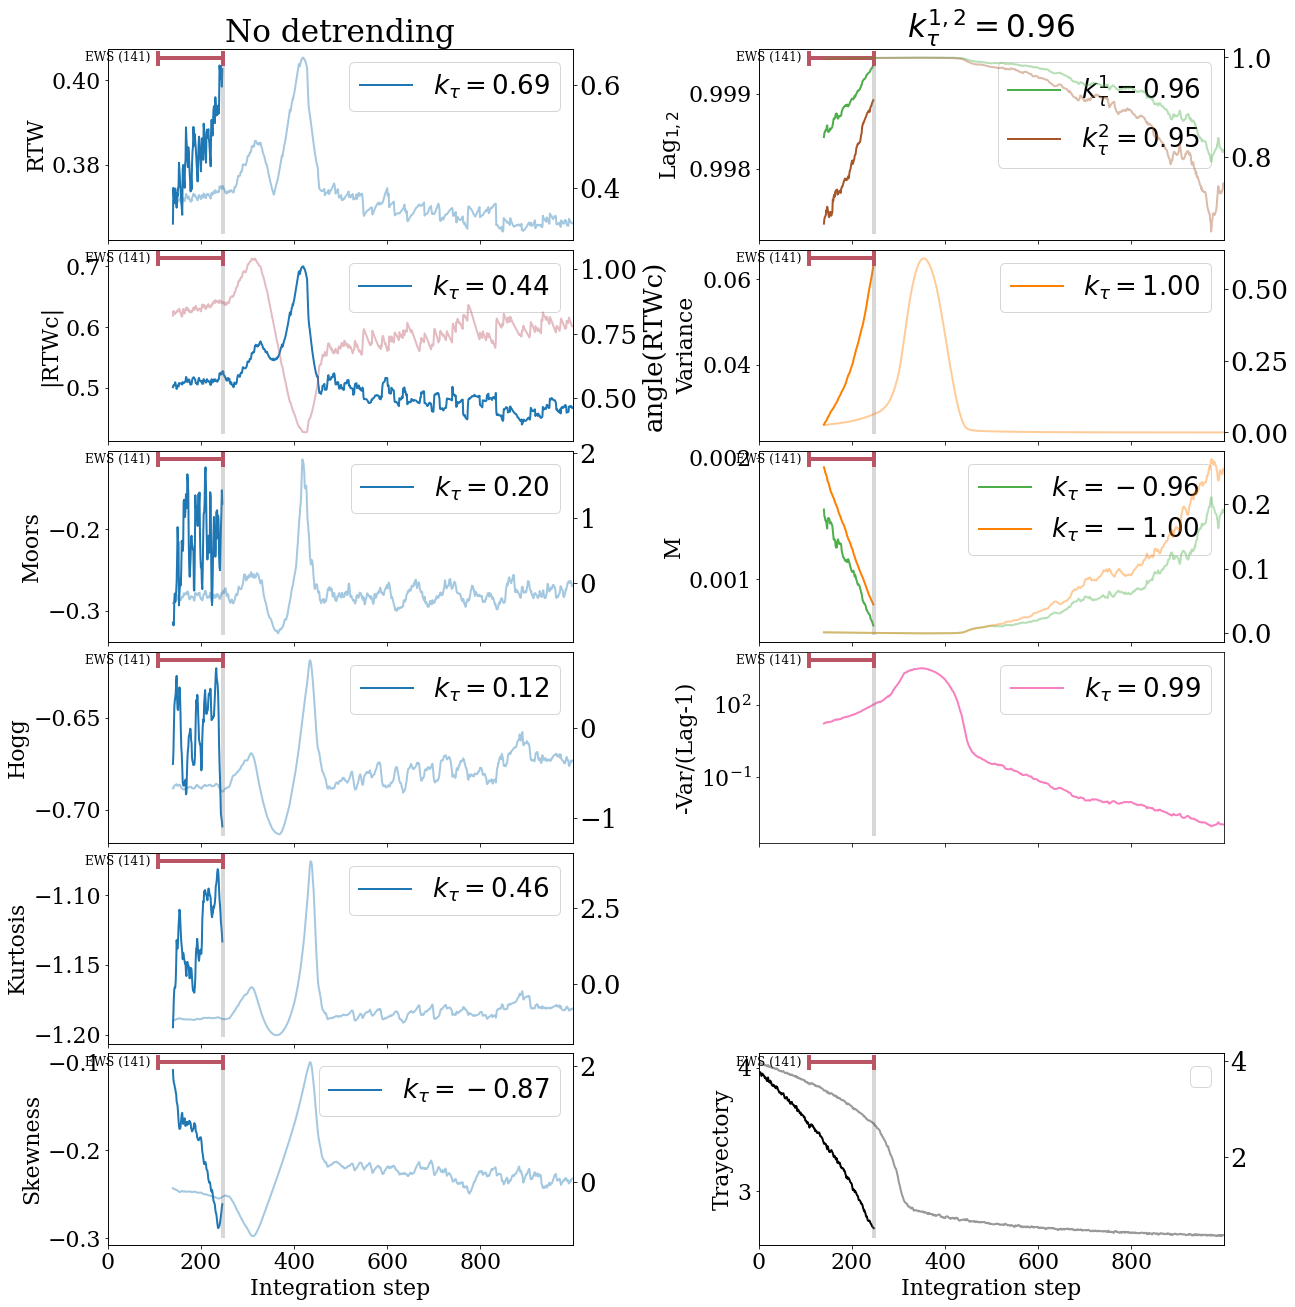

In [15]:

bootstrapping=False
smoothing=False

ts = ews.TimeSeries(data=res)  ### ews stats ### 
tidx,ac_labels,ac1,ac2,var_ews,sk_ews,ku_ews,rtw,hogg2,moors,RTWc= sa.make_stats(tspan,t,ts,varwin,ewswin)

if bootstrapping==True:
    dlen=len(ac1)
    mean_b=np.zeros([dlen,2])
    var_b=np.zeros([dlen,2])
    skew_b=np.zeros([dlen,2])
    kur_b=np.zeros([dlen,2])
    kr2_b=np.zeros([dlen,2])
    kr3_b=np.zeros([dlen,2])
    RTW_b=np.zeros([dlen,2])
    ac1_std=np.zeros([dlen,2])

fig=sa.stats_plot(bif_idx,tidx,ind_f,s,rtw,RTWc,moors,hogg2,ac1,ku_ews,sk_ews,ac2,var_ews,residuals,res,smooth,smoothing,ewswin,datalen*1000)
fig.savefig('./No_det_additive.png'  , dpi = 130, bbox_inches='tight')# when saving, specify the DPI